In [164]:
import gzip
import json
import math
import numpy as np
import random
import sklearn
import string
from collections import defaultdict
from nltk.stem.porter import *
from sklearn import linear_model
import dateutil
from scipy.sparse import lil_matrix 

In [ ]:
train_dataset, val_dataset, test_dataset = [],[],[]

with open("data/filter_all_t.json") as f:
    l = json.load(f)

In [166]:
l.keys()

dict_keys(['train', 'val', 'test'])

In [167]:
for d in l["train"]:
    train_dataset.append(d)

for d in l["val"]:
    val_dataset.append(d)

for d in l["test"]:
    test_dataset.append(d)
    
len(train_dataset), len(val_dataset), len(test_dataset)

(87013, 10860, 11015)

In [ ]:
## sample example of train_dataset
train_dataset[0]

{'business_id': '60567465d335d0abfb415b26',
 'user_id': '101074926318992653684',
 'rating': 4,
 'review_text': 'The tang of the tomato sauce is outstanding. And the crust is a meal, as it should be. Order a whole pie fresh.',
 'pics': ['AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0',
  'AF1QipPWhe1OP80YPU40J6-XIdxbJIe57vKm8TTjve31',
  'AF1QipNuKWM65S9ZFQykvdIhKUliE6K1VBxssTUYyl8d',
  'AF1QipOJng1JS_1hmpfhAVrr7hE89dcoOtdy-Z6cOO9x'],
 'history_reviews': [['101074926318992653684_6056272797d555cc6fb0d147',
   'The pizza here is the real deal, perfect in every way except for the crust, which was more cracker crisp than chewy bread. Also recommend the meatball parmigiana hero, beefy, fluffy, overflowing, tangy, chunky tomato sauce, toothsome bread.'],
  ['101074926318992653684_604a65c2c6dc737bce7e5a3d',
   'Omg the tomato sauce is everything, in the meatball appetizer, pizza & as a dip for that scratch-made focaccia. Farm-fresh salad. A variety of artisan toppings. Ask for the chili oil! Goes

In [339]:
users = {}
business = {}
interactions = []

for d in train_dataset:
    if d["user_id"] not in users.keys(): users[d["user_id"]] = len(users)
    if d["business_id"] not in business.keys(): business[d["business_id"]] = len(business)
    interactions.append((d["user_id"], d["business_id"], d["rating"]))
    
val_interactions = []

for d in val_dataset:
    if d["user_id"] not in users.keys(): users[d["user_id"]] = len(users)
    if d["business_id"] not in business.keys(): business[d["business_id"]] = len(business)
    val_interactions.append((d["user_id"], d["business_id"], d["rating"]))
    
test_interactions = []

for d in test_dataset:
    if d["user_id"] not in users.keys(): users[d["user_id"]] = len(users)
    if d["business_id"] not in business.keys(): business[d["business_id"]] = len(business)
    test_interactions.append((d["user_id"], d["business_id"], d["rating"]))
    
len(users), len(business), len(interactions), len(val_interactions), len(test_interactions)

(36996, 30831, 87013, 10860, 11015)

In [340]:
random.shuffle(interactions)
mean_rating = sum([r for _,_,r in interactions])/len(interactions)

In [341]:
import math
import numpy as np
import random
import torch as torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader, Dataset


In [342]:
class Brentford(nn.Module):
    
    def __init__(self, K, user_size,item_size):
        self.K = K
        self.beta_user = torch.from_numpy(np.random.normal(size=user_size)).type(dtype= torch.float32)
        self.beta_item = torch.from_numpy(np.random.normal(size=item_size)).type(dtype= torch.float32)
        self.gamma_user = torch.from_numpy(np.random.normal(size=(user_size,K))).type(dtype= torch.float32)
        self.gamma_item = torch.from_numpy(np.random.normal(size=(item_size,K))).type(dtype= torch.float32)
        self.alpha = torch.tensor([0.0]).type(dtype= torch.float32) ## zero initialization of alpha
        
        
        self.beta_user.requires_grad = True
        self.beta_item.requires_grad = True
        self.gamma_user.requires_grad = True
        self.gamma_item.requires_grad = True
        self.alpha.requires_grad = True
    
    def forward(self,bu,bi,gu,gi):
        
        return self.alpha + bu + bi+ torch.dot(gu, gi)
            
            
def train(model,lr,lam,train_set,val_set,users,items):
    
    device = None
    # check availability of gpu
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    print ("Running on: ", device)

    optimizer = torch.optim.SGD([model.beta_user, model.beta_item, model.gamma_user, model.gamma_item], lr= lr, weight_decay=1e-4)
    steps = len(train_set)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
    losses = []
    val_losses = []
    
    ts = time.time() 
    loss_tot = []
    for idx, (u,i,r) in enumerate(train_set):
        optimizer.zero_grad()
        
        beta_u = model.beta_user[users[u]]
        beta_i = model.beta_item[items[i]]
        gamma_u = model.gamma_user[users[u],:]
        gamma_i = model.gamma_item[items[i],:]
        
        y = torch.tensor([float(r)])
        pred = model.forward(beta_u,beta_i,gamma_u,gamma_i) 
        loss = (pred-y)**2+lam*(beta_u+\
                beta_i+ torch.norm(gamma_u)+torch.norm(gamma_i))
        loss.backward()
        
        #print(model.beta_user[users[u]],model.beta_item[items[i]],model.gamma_user[users[u],:],model.gamma_item[items[i],:])
        optimizer.step()
        #scheduler.step()
        loss_tot.append(loss)
        if idx % 100 == 0:
                print("iter {}, loss: {}".format(idx, loss.item()))
                #print(model.beta_user[users[u]],model.beta_item[items[i]],model.gamma_user[users[u],:],model.gamma_item[items[i],:])
                losses.append(torch.mean(torch.tensor(loss_tot)).item())
                loss_tot = []
                val_losses.append(val(model,val_set,users,items))
                #print("iter: {}, validation loss: {}".format(idx, val_losses[-1]))
    return losses, val_losses

def val(model,val_set,users,items):
    loss_tot = []
    with torch.no_grad():
        for idx, (u,i,r) in enumerate(val_set):
            if u in users.keys() and i in items.keys():
                beta_u = model.beta_user[users[u]]
                beta_i = model.beta_item[items[i]]
                gamma_u = model.gamma_user[users[u],:]
                gamma_i = model.gamma_item[items[i],:]
                pred = model.forward(beta_u,beta_i,gamma_u,gamma_i)
            else:
                pred = mean_rating   

            y = torch.tensor([float(r)])
            loss = (pred-y)**2
            loss_tot.append(loss)
            #if idx % 100 == 0:
                #print("iter {}, loss: {}".format(idx, loss.item()))
                #print(model.beta_user[users[u]],model.beta_item[items[i]],model.gamma_user[users[u],:],model.gamma_item[items[i],:])
    losses = torch.mean(torch.tensor(loss_tot)).item()

    return losses

In [398]:
b_lfm = Brentford(2,len(users),len(business))

In [ ]:
loss, val_loss = train(b_lfm,0.1,0.01,interactions,val_interactions,users,business)

Running on:  cpu
iter 0, loss: 11.035975456237793
iter 100, loss: 17.3861141204834
iter 200, loss: 14.193573951721191
iter 300, loss: 1.2378283739089966
iter 400, loss: 33.085533142089844
iter 500, loss: 27.24587059020996
iter 600, loss: 2.5150418281555176
iter 700, loss: 39.25248718261719
iter 800, loss: 27.082555770874023
iter 900, loss: 1.9904577732086182
iter 1000, loss: 21.959692001342773
iter 1100, loss: 23.380306243896484
iter 1200, loss: 13.607098579406738
iter 1300, loss: 6.1459150314331055
iter 1400, loss: 19.725658416748047
iter 1500, loss: 24.472238540649414
iter 1600, loss: 23.359081268310547
iter 1700, loss: 30.11672019958496
iter 1800, loss: 7.369534969329834
iter 1900, loss: 27.148942947387695
iter 2000, loss: 8.084759712219238
iter 2100, loss: 19.780824661254883
iter 2200, loss: 5.99857759475708
iter 2300, loss: 21.469863891601562
iter 2400, loss: 3.0938642024993896
iter 2500, loss: 22.273828506469727
iter 2600, loss: 29.92124366760254
iter 2700, loss: 51.0950431823730

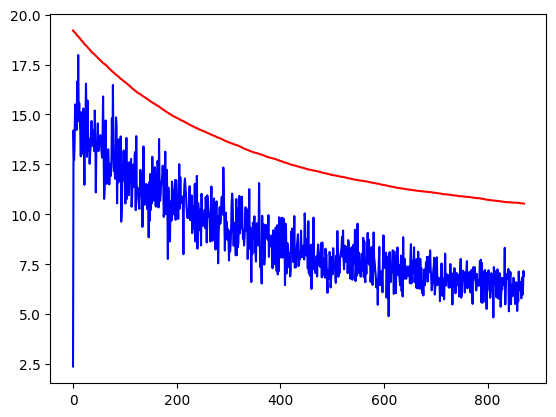

In [379]:
from matplotlib import pyplot as plt

## plot training and validation losses
plt.plot(np.arange(len(loss)),loss,c="b")
plt.plot(np.arange(len(val_loss)),val_loss,c="r")

In [380]:
def test(model,test_set,users,items):
    predictions=[]
    labels = []
    loss_tot = []
    losses = []
    with torch.no_grad():
        for idx, (u,i,r) in enumerate(test_set):
            if u in users.keys() and i in items.keys():
                beta_u = model.beta_user[users[u]]
                beta_i = model.beta_item[items[i]]
                gamma_u = model.gamma_user[users[u],:]
                gamma_i = model.gamma_item[items[i],:]
                pred = model.forward(beta_u,beta_i,gamma_u,gamma_i)
            else:
                pred = mean_rating   

            y = torch.tensor([float(r)])
            labels.append((y))
            predictions.append((u,i,pred))
            loss = (pred-y)**2
            
            loss_tot.append(loss)
            if idx % 100 == 0:
                losses.append(torch.mean(torch.tensor(loss_tot)).item())
                loss_tot = []
    return losses, predictions

In [381]:
## testing the data
test_losses, test_precitions = test(b_lfm,test_interactions,users,business)

In [382]:
metrics = {}

In [383]:
def MRR(predictions,labels,users,items,k=3):
    userRanks = defaultdict(list)
    labelRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for (u,i,p) in labels:
        labelRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
    
    for u in labelRanks:
        labelRanks[u].sort(reverse=True)
    
    totalMRR = 0
    
    for u, preds in userRanks.items():
        rank = 0
        ps = [p[1] for p in labelRanks[u][:k]]
        for i, (r,b) in enumerate(preds):
            if b in items and b in ps:
                rank = i+1
                break
            
        if rank > 0:
            totalMRR += 1/rank
    
    return totalMRR/len(userRanks) if len(userRanks) > 0 else 0

In [384]:
mean_reciproal_rank = MRR(test_precitions,test_interactions,users,business)
mean_reciproal_rank
metrics["MRR"] = mean_reciproal_rank

In [385]:
mean_MSE =  sum(test_losses)/len(test_losses)
mean_MSE
metrics["average MSE"] = mean_MSE

In [386]:
def NDCG(predictions,labels,users,items,k=3):
    userRanks = defaultdict(list)
    labelRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for (u,i,p) in labels:
        labelRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
    
    for u in labelRanks:
        labelRanks[u].sort(reverse=True)
        
    totalDCG = 0
    for u, preds in userRanks.items():
        rank = 0
        rating = 0
        ps = [p[1] for p in labelRanks[u][:k]]
        for i, (r,b) in enumerate(preds):
            if b in items and b in ps:
                rank = i+1
                rating = r
                totalDCG += rating/np.log2(rank+1)
    
    totalIDCG = 0
    for u,preds in labelRanks.items():
        rank = 0
        rating = 0
        for i, (r,b) in enumerate(preds[:k]):
            if b in items:
                rank = i+1
                rating = r
                totalIDCG += rating/np.log2(rank+1)

    return totalDCG, totalDCG/totalIDCG

In [387]:
DCG3, NDCG3 = NDCG(test_precitions, test_interactions, users, business)
DCG3, NDCG3

metrics["NDCG"] = NDCG3

In [388]:
def Precision(predictions,labels,users,items,k=3):
    userRanks = defaultdict(list)
    labelRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for (u,i,p) in labels:
        labelRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
    
    for u in labelRanks:
        labelRanks[u].sort(reverse=True)
        
    totalPreKU = 0
    for u, preds in userRanks.items():
        relevance = 0
        ps = [p[1] for p in labelRanks[u][:k]]
        for i, (r,b) in enumerate(preds):
            if b in items and b in ps:
                relevance+=1
        totalPreKU += relevance/k

    return totalPreKU/len(users)

def Recall(predictions,labels,users,items,k=3):
    userRanks = defaultdict(list)
    labelRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for (u,i,p) in labels:
        labelRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
    
    for u in labelRanks:
        labelRanks[u].sort(reverse=True)
        
    totalRKU = 0
    for u, preds in userRanks.items():
        relevance = 0
        ps = [p[1] for p in labelRanks[u][:k]]
        for i, (r,b) in enumerate(preds):
            if b in items and b in ps:
                relevance+=1
        totalRKU += relevance/len(preds)

    return totalRKU/len(users)
                    

In [389]:
P3 = Precision(test_precitions,test_interactions,users,business)
P3
metrics["precision"] = P3

In [390]:
R3 = Recall(test_precitions,test_interactions, users, business)
R3
metrics["recall"] = R3

In [391]:
metrics

{'MRR': 0.9494267579267582,
 'average MSE': 10.68137129362639,
 'NDCG': tensor([0.3590]),
 'precision': 0.0796752802104708,
 'recall': 0.09160845409258413}

In [392]:
## Recommender function given a 
def recommendTopNRestaurants(predictions, n=3):
    topN = defaultdict(list)
    for (u,i,p) in predictions:
        topN[u].append((p, i))
    # for uid, ratings in topN.items():
    #     ratings.sort(key=lambda x: x[1], reverse=True)
    #     topN[uid] = ratings[:n]
    for u, ratings in topN.items():
        ratings.sort(reverse=True)
        topN[u] = ratings[:n]
    return topN

In [393]:
top3 = recommendTopNRestaurants(test_precitions)
for u, recs in top3.items():
    print(f"User {u}: {recs}")

User 108919790647235091207: [(tensor([2.3215]), '6055eda33019cb0a47838b25'), (tensor([0.9379]), '604ba46f20f26f37fb9d7d69'), (tensor([-0.4625]), '604bf6a75041fa50c4bce594')]
User 108111397722253060630: [(tensor([3.6163]), '604ee8b388c7af3f893e613b'), (tensor([2.6569]), '604bca76d40e4bc9b841777c'), (tensor([0.9858]), '6041e2e8475f3961ca526f49')]
User 114961509003938009497: [(tensor([2.3557]), '60519f27a740b9d848c0aad7'), (tensor([2.1052]), '605121e75b4ccec8d5caea76'), (tensor([0.8580]), '6055a6683019cb0a478389d5')]
User 108970514621946615447: [(tensor([2.8597]), '6047d70ab1a0aaee3eef9334'), (tensor([2.3121]), '604d3f3cd42e9b5974480ddd'), (tensor([1.8902]), '6050d2cf9c93e55e75b72260')]
User 113922271624881467869: [(tensor([2.2792]), '60413085c6fcf1fddba11e1d'), (tensor([2.0181]), '604a82ceb1a0aaee3eefbc62'), (tensor([1.8008]), '6046315010ec061e056b3f81')]
User 106054094716897428670: [(tensor([0.9042]), '6040ac0a9d953d1f97fa1903'), (tensor([0.2459]), '604ced1677e81aaed3cca3f7')]
User 1112

In [ ]:
f = open("PyTorch Metrics.txt", 'w')
f.write(str(metrics) + '\n')
f.close()